In [94]:
import numpy as np
import math
from PIL import Image
from skimage import data
from matplotlib import image
import matplotlib.pyplot as plt
%matplotlib inline

pic = image.imread('road.png')
im = Image.open('road.png')

In [95]:
print(pic.dtype)

float32


In [96]:
print(pic.shape)

(407, 548, 4)


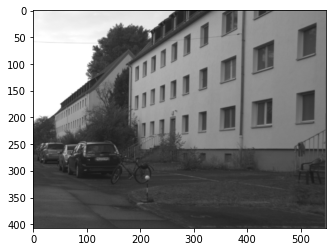

In [97]:
plt.imshow(im)

In [98]:
data = np.asarray(pic)
val = np.asarray(im)

In [99]:
print(data[0])

[[0.95686275 0.95686275 0.95686275 1.        ]
 [0.95686275 0.95686275 0.95686275 1.        ]
 [0.9607843  0.9607843  0.9607843  1.        ]
 ...
 [0.5137255  0.5137255  0.5137255  1.        ]
 [0.50980395 0.50980395 0.50980395 1.        ]
 [0.50980395 0.50980395 0.50980395 1.        ]]


In [100]:
print(val)
print(val.shape)
max_val = np.amax(val)
min_val = np.amin(val)
print(max_val)
print(min_val)

[[244 244 245 ... 131 130 130]
 [242 243 243 ... 130 131 131]
 [241 241 241 ... 130 132 131]
 ...
 [ 67  69  69 ...  50  84  84]
 [ 68  69  67 ...  53  84  84]
 [ 67  72  69 ...  61  84  84]]
(407, 548)
255
23


In [101]:
def gaussianKernel(sigma, size):
    filter = np.zeros((size, size))
    c = size // 2
    for x in range(-c, c+1):
        for y in range(-c, c+1):
            val1 = 2*np.pi*(sigma**2)
            val2 = np.exp(-(x**2 + y**2)/(2*sigma**2))
            filter[x+c, y+c] = (1/val1)*val2
            
    return filter

def imagePadding(image, kernel):
    return np.pad(image, pad_width=(kernel.shape[1] // 2, kernel.shape[0] // 2))

def convolution(image, kernel):
    size = kernel.shape[0]
    padded_image = imagePadding(image, kernel)
    conv_image = np.zeros(padded_image.shape)
    center_x = kernel.shape[1] // 2
    center_y = kernel.shape[0] // 2
    
    result_image = np.zeros(padded_image.shape)
    
    for i in range(center_x, padded_image.shape[1]-center_x):
        for j in range(center_y, padded_image.shape[0]-center_y):
            window = padded_image[j-center_y:j-center_y+size, i-center_x:i-center_x+size]
            filter_v = window.flatten() * kernel.flatten()
            result_image[j][i] = np.sum(filter_v)
            
    return result_image[center_y:-center_y, center_x:-center_x]

In [102]:
def gaussianFilter(imageMatrix, sigma, size):
    kernel = gaussianKernel(sigma, size)
    print(kernel)
    return convolution(imageMatrix, kernel)

[[0.01463746 0.02129738 0.02413309 0.02129738 0.01463746]
 [0.02129738 0.0309875  0.03511344 0.0309875  0.02129738]
 [0.02413309 0.03511344 0.03978874 0.03511344 0.02413309]
 [0.02129738 0.0309875  0.03511344 0.0309875  0.02129738]
 [0.01463746 0.02129738 0.02413309 0.02129738 0.01463746]]
F


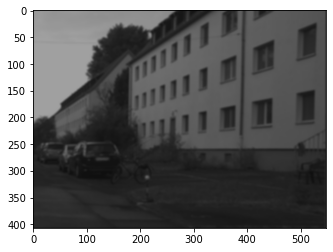

In [103]:
gaussianImage = gaussianFilter(val, 2, 5)
gaussian = Image.fromarray(gaussianImage)
plt.imshow(gaussian)
print(gaussian.mode)

In [104]:
sobel_x = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
sobel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
def sobelXFilter(image):
    return convolution(image, sobel_x)
def sobelYFilter(image):
    return convolution(image, sobel_y)

In [105]:
sobelXImage = sobelXFilter(sobelXFilter(gaussianImage))
sobelYImage = sobelYFilter(sobelYFilter(gaussianImage))

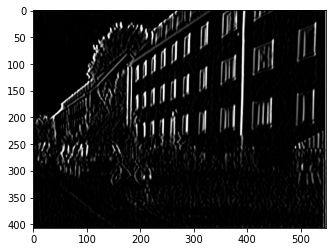

In [106]:
sobelX = Image.fromarray(sobelXImage)
plt.imshow(sobelX)

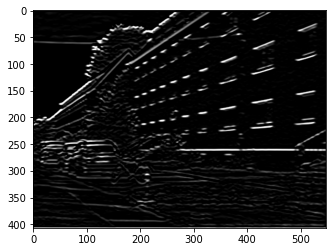

In [107]:
sobelY = Image.fromarray(sobelYImage)
plt.imshow(sobelY)

F


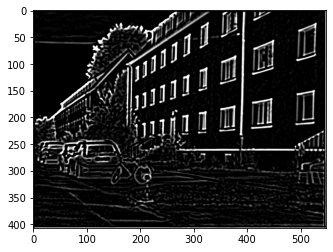

In [131]:
sobelXY = Image.fromarray(sobelXImage+sobelYImage)
plt.imshow(sobelXY)
print(sobelXY.mode)

In [136]:
def nonMaxSupression(image, max_val, min_val):
    supress = image.copy()
    for i in range(1, image.shape[1]-1):
        for j in range(1, image.shape[0]-1):
            max_neighbor = np.amax(image[j-1:j+2, i-1:i+2])
            if(image[j][i] != max_neighbor):

                supress[j][i] = min_val
            else:
                supress[j-1:j+2, i-1:i+2] = min_val
                supress[j][i] = image[j][i]
                
    return supress

def hessianFilter(image, threshold = 150):
    det = np.zeros(image.shape)
    sobelDetImage = sobelXFilter(sobelYFilter(gaussianImage))
    
    det = sobelXImage * sobelYImage - sobelDetImage**2

    max_val = np.amax(det)
    min_val = np.amin(det)
    
    return nonMaxSupression(det,max_val,min_val)

(407, 548)


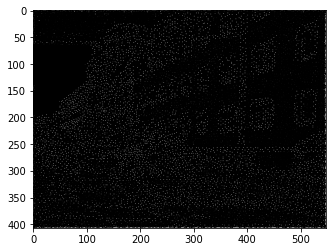

In [137]:
hessianImage = hessianFilter(sobelXImage+sobelYImage)
hessian = Image.fromarray(hessianImage).convert('P')
print(hessianImage.shape)
plt.imshow(hessian)

In [144]:
def pointList(image):
    return np.nonzero(image > 0)

def randomTwoPoint(size):
    p1 = np.random.randint(0, size - 1)
    
    p2 = np.random.randint(0, size - 1)
    
    while(p1 == p2):
        p2 = np.random.randint(0, size - 1)
        
    return p1, p2

def points(pointListX, pointListY):
    for i in range(0, len(pointListX) - 1):
        yield pointListY[i], pointListX[i], i

def lineTwoPoint(x1, y1, x2, y2):
    if x1 == x2:
        m = math.inf
    else:
        m = (y1-y2)/(x1-x2)
        
    c = -m*x2 + y2
    
    return m, c

def distanceFromLine(x, y, m, c):
    intersect_x = (x + (m * y) - (m * c) / (1 + m**2))
    intersect_y = ((m * x) + ((m**2) * y) - ((m**2) * c)) / (1 + m**2) + c
    
    distance = math.sqrt((intersect_x - x)**2 + (intersect_y - y)**2)
    
    return intersect_x, intersect_y, distance
        
def RANSAC(image, in_limit, dist_limit, num_line=4):
    line = 0
    pointY,pointX = pointList(image)
    output = image.copy()
    while(line < num_line):
        p1, p2 = randomTwoPoint(len(pointY))
        
        slope, constant = lineTwoPoint(pointX[p1],pointY[p1],pointX[p2],pointY[p2])
        
        inliners = []
        
        for y, x, i in points(pointY, pointX):
            dist, p_x, p_y = distanceFromLine(y, x, slope, constant)
            if(dist < dist_limit):
                inliners.append(i)
            
        if(len(inliners) >= in_limit):
#             for p in inliners:
#                 output[pointY[p]-1:pointY[p]+2, pointX[p]-1:pointX[p]+2] = 255
                
            pointX.take(inliners)
            pointY.take(inliners)
        line+=1
    print(image.shape)
    return output
    

(407, 548)
P


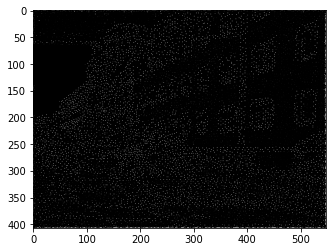

In [145]:
input_image = np.asarray(hessian)
ransacImage = RANSAC(input_image, 40, 4)
ransac = Image.fromarray(ransacImage).convert('P')
plt.imshow(ransac)
print(ransac.mode)